## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import cufflinks as cf
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
# from sklearn.linear_model import BayesianRidge
# from catboost import CatBoostRegressor
# from sklearn.kernel_ridge import KernelRidge
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor


import plotly.graph_objects as px


# Int cufflinks
# making all charts public and setting a global theme
cf.set_config_file(theme='ggplot',offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set matplotlib in Darkmode
# plt.style.use('light_background')

# Set Pandas to display all columsn
pd.set_option("display.max.columns", None)


: 

# Dataset Overview

### 01. Load the dataset

In [ ]:
dataset = pd.read_csv('yield_df.csv', encoding='utf-8', index_col=[0])

### 02. Explore the dataset

Explore files

In [ ]:
# Whole dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


Select files (<i>yield_df.csv</i>)

In [ ]:
dataset.head(5)

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [ ]:
# Columns
columns = list(dataset.columns)
dataset.columns

Index(['Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year',
       'pesticides_tonnes', 'avg_temp'],
      dtype='object')

In [ ]:
# Crops available 
dataset.Item.unique()


array(['Maize', 'Potatoes', 'Rice, paddy', 'Sorghum', 'Soybeans', 'Wheat',
       'Cassava', 'Sweet potatoes', 'Plantains and others', 'Yams'],
      dtype=object)

In [ ]:
# Shows NA or NAN
dataset.isna().any()

Area                             False
Item                             False
Year                             False
hg/ha_yield                      False
average_rain_fall_mm_per_year    False
pesticides_tonnes                False
avg_temp                         False
dtype: bool

In [ ]:
dataset.describe()

In [ ]:
# Skew 
dataset.skew(numeric_only=True)

Year                             0.012243
hg/ha_yield                      1.793229
average_rain_fall_mm_per_year    0.853832
pesticides_tonnes                3.490289
avg_temp                        -0.741582
dtype: float64

Train model for different items separately?

In [ ]:
dataset.groupby('Item').count()



### Plot Data

#### 03. Plot all variables

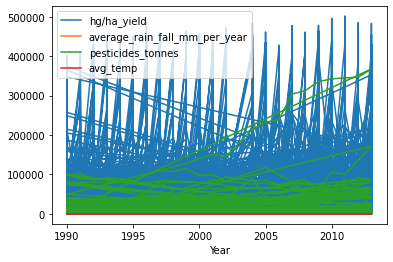

In [ ]:
dataset.plot(x='Year')

(1.0, 100.0)

<Figure size 1440x576 with 0 Axes>

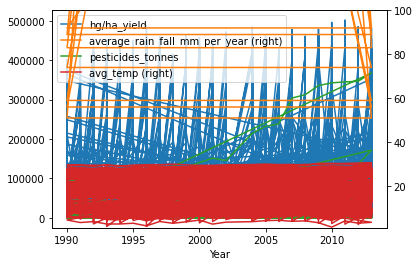

In [ ]:
# Plot all variables against time
plt.figure(figsize=(20,8))
ax = dataset.plot.line(secondary_y=['avg_temp','average_rain_fall_mm_per_year'], x='Year', rot=0)
ax.right_ax.set_ylim(1,100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89a0223430>,
      dtype=object)

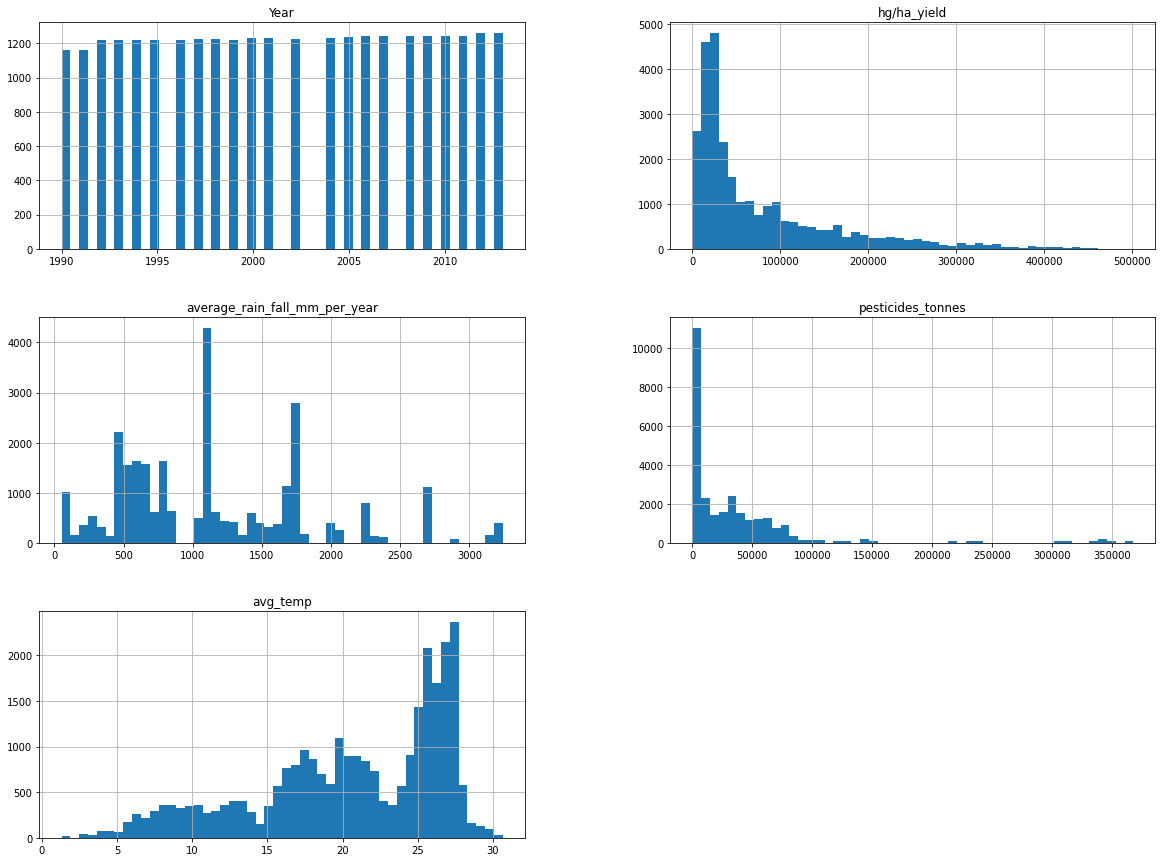

In [ ]:
#Plot histograms of all the variables in the dataset
dataset.hist(bins=50, figsize = (20,15))

#### 04. Correlation matrix

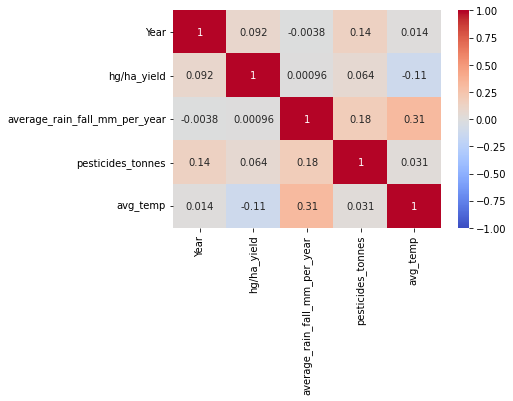

In [ ]:
# Correlation data 
corr = dataset.corr()

# Correlation matrix with seaborn (correlation val are -1 to 1, thats why vmin vmax)
sns.heatmap(corr, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

# Model Comparison

## Functions

#### Checking Parameters

In [ ]:
def parameter_check(pred, labels_test):
    """Determines r2, mae, rmse and adjusted r2"""
    # Calculate R-squared
    r2 = r2_score(labels_test , pred)
    print("R-squared:", r2)

    # Calculate MAE
    mae = mean_absolute_error(labels_test, pred)
    print("MAE:", mae)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(labels_test, pred))
    print("RMSE:", rmse)

    # Calculate Adjusted R-squared
    n = len(labels_test)
    p = len(pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print("Adjusted R-squared:", adj_r2)
    
    return { 'r2': r2, 'mae':mae, 'rmse':rmse, 'adj_r2':adj_r2}

#### Regressors

In [ ]:
def run_regressor(regressor, features_train, labels_train, features_test, labels_test) -> dict:
    # Fit data for training into regressor
    regressor.fit(features_train , labels_train)
    # Predicting with regressor
    pred = regressor.predict(features_test)
    return parameter_check(pred, labels_test)

#### Pipeline

In [ ]:
def build_pipeline(params, regressor, features_train, labels_train, features_test, labels_test, rkf=False):
    # Setting up a pipeline
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('imputer', None),
        ('balancing', None),
        ('rgs', regressor)
    ])

    # Cross validation
    if rkf:
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    else:
        cv = KFold(n_splits=5,random_state=42,shuffle=True)

    # Set up the grid search
    gs = GridSearchCV(estimator=pipe,param_grid=params,n_jobs=-1, verbose=5, cv=5,scoring='r2')

    # Fit gs to training data
    gs_results = gs.fit(features_train, labels_train)

    # Find best fit
    print(f'Best score: {gs_results.best_score_}')
    print(f'Best parameters: \n{gs_results.best_params_}')

    # Get score
    print(f'\nScore: {gs.score(features_test, labels_test)}')

    # Predict results
    labels_preds = gs.predict(features_test)
    best_par = parameter_check(labels_preds, labels_test)

    return best_par, gs_results

In [ ]:
# Parameter grids to search over using gridsearch (for each algorithm)
params = {
'svm' : {
    # 'scaler':[StandardScaler(), MinMaxScaler()],
    # 'rgs__degree':[0.001, 0.01, 0.1, 1, 10],
    # 'rgs__gamma' : [1,2,3,4,5],
    # 'rgs__kernel' :['rbf', 'linear', 'poly' ,'sigmoid'],
    'rgs__C' : [10, 100],
    # 'rgs__coef0': [0.01, 10, 0.5]
    'rgs__epsilon': [0.1, 0.5, 1],
},
'rf': {
    'rgs__n_estimators':[5, 10, 50,],
    'rgs__max_depth': [5, 10, 20],
    'rgs__min_samples_split': [2,3,4],
    'rgs__min_samples_leaf': [3,5]
},
'ada':{
    'rgs__n_estimators':[10, 50, 100, 500],
    'rgs__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
},
'elastic':{
    'rgs__alpha':[0.01, 0.1, 1.0, 2,0, 10.0,],
    'rgs__l1_ratio':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
},
'xgb':{
    'rgs__n_estimators': [100,250,400],
    'rgs__max_depth': [3, 6, 9],
    'rgs__learning_rate': [0.05, 0.1, 0.20],
    'rgs__min_child_weight': [1, 10, 100]
    
},
'sgdr' : {
    'rgs__alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
    'rgs__l1_ratio':np.arange(0, 1, 0.1),

},
'lgbmr' : {
    'rgs__n_estimators': [50, 100, 400],
    'rgs__max_depth': [-1, 0, 1],
    'rgs__learning_rate': [0.05, 0.1, 0.20],
    'rgs__min_child_weight': [0.001, 0.01, 0.1]
    
}
}

## Data Preprocessing

### 04. Handle Categorical Variables

In [ ]:
# Handle categorical variables
# OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# fit and transform the categorical data in Area and Item
encoded_data = encoder.fit_transform(dataset[['Item', 'Area']])

# convert the encoded data back into a Pandas DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names(['Item', 'Area']))
df = pd.concat([dataset, encoded_df], axis=1)

### 05. Remove Unnecesary Features

In [1]:
# Create features and labels (and remove categorical variables)
features = df.drop(['hg/ha_yield','Item','Area', 'Year'], axis=1)
labels = df['hg/ha_yield']

NameError: name 'df' is not defined

### 06. Split Dataset

In [ ]:
# Create training (75%) and test (25%) sets
features_train, features_test , labels_train , labels_test = train_test_split(features, labels, test_size =0.25)
len(features_train), len(features_test), len(labels_train), len(labels_test)

(21181, 7061, 21181, 7061)

### 06. Run Models

SVM

In [ ]:
best_par_svm, score_svm = build_pipeline(params['svm'], SVR(), features_train, labels_train, features_test, labels_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score: 0.30857249070209286
Best parameters: 
{'rgs__C': 100, 'rgs__epsilon': 1}

Score: 0.3769507670200939
R-squared: 0.3769507670200939
MAE: 35405.12759772639
RMSE: 66690.42568608731
Adjusted R-squared: 4399.727584838137


Random Forest

In [ ]:
best_par_rf, score_rf = build_pipeline(params['rf'], RandomForestRegressor(), features_train, labels_train, features_test, labels_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best score: 0.9807726699865708
Best parameters: 
{'rgs__max_depth': 20, 'rgs__min_samples_leaf': 3, 'rgs__min_samples_split': 3, 'rgs__n_estimators': 50}

Score: 0.9822700813373246
R-squared: 0.9822700813373246
MAE: 4968.138634592896
RMSE: 11250.081749931338
Adjusted R-squared: 126.17322575848812


AdaBoost

In [ ]:
best_par_ada, score_ada = build_pipeline(params['ada'], AdaBoostRegressor(), features_train, labels_train, features_test, labels_test, rkf=True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score: 0.6828554370193297
Best parameters: 
{'rgs__learning_rate': 0.1, 'rgs__n_estimators': 10}

Score: 0.6833631895571232
R-squared: 0.6833631895571232
MAE: 32853.0331994809
RMSE: 47542.60865917738
Adjusted R-squared: 2236.4558817267107


Elastic Net

In [ ]:
best_par_elastic, score_elastic = build_pipeline(params['elastic'], ElasticNet(), features_train, labels_train, features_test, labels_test)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best score: 0.7551527128676384
Best parameters: 
{'rgs__alpha': 0, 'rgs__l1_ratio': 0.1}

Score: 0.7482312858832167
R-squared: 0.7482312858832167
MAE: 29639.047615845873
RMSE: 42393.882090076586
Adjusted R-squared: 1778.4871216644897


X-Gradient Boost

In [ ]:
best_par_xgb, score_xgb = build_pipeline(params['xgb'], XGBRegressor(), features_train, labels_train, features_test, labels_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[20:11:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 0.986107629259857
Best parameters: 
{'rgs__learning_rate': 0.2, 'rgs__max_depth': 9, 'rgs__min_child_weight': 1, 'rgs__n_estimators': 400}

Score: 0.9872983797586765
R-squared: 0.9872983797586765
MAE: 4214.682746356682
RMSE: 9522.080936804143
Adjusted R-squared: 90.67343890374381


SGDR Regressor

In [ ]:
best_par_sgdr, score_sgdr = build_pipeline(params['sgdr'], SGDRegressor(), features_train, labels_train, features_test, labels_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best score: 0.7539638080301188
Best parameters: 
{'rgs__alpha': 0.0, 'rgs__l1_ratio': 0.5}

Score: 0.746645856889091
R-squared: 0.746645856889091
MAE: 29706.27579725601
RMSE: 42527.15323518629
Adjusted R-squared: 1789.6802503630174


LGBM Regressor

In [ ]:
best_par_lgbmr, score_lgbmr = build_pipeline(params['lgbmr'], LGBMRegressor(), features_train, labels_train, features_test, labels_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best score: 0.9772876800452245
Best parameters: 
{'rgs__learning_rate': 0.2, 'rgs__max_depth': -1, 'rgs__min_child_weight': 0.001, 'rgs__n_estimators': 400}

Score: 0.9774882552849797
R-squared: 0.9774882552849797
MAE: 6623.640539404373
RMSE: 12676.719603647529
Adjusted R-squared: 159.93291768804306


### 07. Comparison

#### Parameter Comparison

In [ ]:
# Plot out different parameters
compare = [best_par_svm, best_par_rf, best_par_ada, best_par_elastic, best_par_xgb, best_par_sgdr, best_par_lgbmr ]
headers_comparison = ['SVM','RandomForest','AdaBoost', 'ElasticNet', 'XGradBoost', 'SGDR', 'LGBMR']

In [ ]:
compare_df = pd.DataFrame(compare)
compare_df["results"]=headers_comparison
compare_df = compare_df.set_index('results', drop=True).rename_axis(None)
compare_df

,r2,mae,rmse,adj_r2
SVM,0.376951,35405.127598,66690.425686,4399.727585
RandomForest,0.982270,4968.138635,11250.081750,126.173226
AdaBoost,0.683363,32853.033199,47542.608659,2236.455882
ElasticNet,0.748231,29639.047616,42393.882090,1778.487122
XGradBoost,0.987298,4214.682746,9522.080937,90.673439
SGDR,0.746646,29706.275797,42527.153235,1789.680250
LGBMR,0.977488,6623.640539,12676.719604,159.932918


XGradBoost has great r2 and the lowest mae, so we'll be using that.

In [ ]:
# compare_df = compare_df.drop(['SGDR'])
compare_df = compare_df.T
compare_df
# compare_df.plot(kind='bar', width=0.9)

AttributeError: ignored

#### Score Comparison

In [ ]:
def get_scores(gs_results):
    """Return hs_results in dictionary"""
    return {
        'Best Score' : gs_results.best_score_,
        'Best parameters': gs_results.best_params_,
        'Means' : gs_results.cv_results_['mean_test_score'],
        'Stds' : gs_results.cv_results_['std_test_score'],
        'Params' : gs_results.cv_results_['params']
        }

In [ ]:
# Plot out different parameters
score_objects = [score_svm, score_rf, score_ada, score_elastic, score_xgb, score_sgdr, score_lgbmr ]
compare2 = [ get_scores(x) for x in score_objects  ]

compare_df2 = pd.DataFrame(compare2)
compare_df2["results"]=headers_comparison
compare_df2 = compare_df2.set_index('results', drop=True).rename_axis(None)

In [ ]:
compare_df2

In [ ]:
# compare_df2['Best Score'].T.iplot(kind='bar')

In [ ]:
def plot_box(data):
    plot = px.Figure()

    for i,each in enumerate(data.to_list()):
        plot.add_trace(px.Box(y=each, boxmean=True, name=headers_comparison[i]))

    plot.update_layout(template='plotly_dark', title="Algorthm Comparison")
    plot.show()